In [11]:
import math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.stats import chi2, poisson, t


def cmp_float(lhs, rhs):
    return math.fabs(lhs - rhs) < 0.001


def check_distr_func(distr_func, var, low, high) -> bool:
    low_val = float(distr_func.subs(var, low).evalf())
    if not cmp_float(low_val, 0):
        return False
    high_val = float(distr_func.subs(var, high).evalf())
    if not cmp_float(high_val, 1):
        return False
    return True


def calc_statistical_mean(values: list) -> float:
    return sum(values) / len(values)


def calc_dispersion(values: list) -> float:
    sum = 0
    m = calc_statistical_mean(values)
    for i in values:
        sum += (i - m) ** 2
    return sum / (len(values) - 1)


def create_histogram(values: list, intervals_num: int) -> None:
    plt.hist(values, bins=intervals_num)
    plt.show()


def calc_distr_density(distr_func, var):
    distr_density = distr_func.diff(var)
    return distr_density


def calc_math_expectation(distr_density, var, low, high):
    math_expectation = sp.integrate(distr_density * var, (var, low, high))
    return float(math_expectation)


def calc_theoretical_dispersion(distr_density, var, low, high):
    math_expectation = calc_math_expectation(distr_density, var, low, high)
    dispersion = float(sp.integrate((var ** 2) * distr_density, (var, low, high))) - math_expectation ** 2
    return dispersion


def calc_mean_confidence_interval(data: list, confidence_level: float) -> tuple:
    mean = calc_statistical_mean(data)
    dispersion = calc_dispersion((data))
    n = len(data)
    tmp = t.ppf(confidence_level, n - 1)
    eps = np.sqrt(dispersion) * tmp / np.sqrt(n - 1)
    return (mean - eps, mean + eps)


def calc_standard_deviation_conf_interval(data: list, confidence_level: float) -> tuple:
    mean = calc_statistical_mean(data)
    dispersion = calc_dispersion(data)
    standard_deviation = np.sqrt(dispersion)

    n = len(data)

    a1 = (1 - confidence_level) / 2.0
    a2 = (1 + confidence_level) / 2.0

    standard_deviation_left = np.sqrt((n - 1) / chi2.ppf(a2, n - 1)) * standard_deviation
    standard_deviation_right = np.sqrt((n - 1) / chi2.ppf(a1, n - 1)) * standard_deviation
    return (standard_deviation_left, standard_deviation_right)


def build_statistical_series(values: list, intervals_num: int, ):
    intervals = np.linspace(0, np.max(values), intervals_num)
    statistical_series = {(intervals[i], intervals[i + 1]): 0 for i in range(len(intervals) - 1)}
    for element in values:
        for i in range(len(intervals) - 1):
            if element >= intervals[i] and element < intervals[i + 1]:
                statistical_series[(intervals[i], intervals[i + 1])] += 1
                break
    return statistical_series


def test_hypothesis(statistical_series, distr_func, var, significance_level):
    # Хи квадрат
    n = sum(statistical_series.values())
    curr_chi2 = 0
    for key, value in statistical_series.items():
        pi = float(distr_func.subs(var, key[1]).evalf()) - float(distr_func.subs(var, key[0]).evalf())
        npi = pi * n
        curr_chi2 += ((value - npi) ** 2) / value
    crit_chi2 = chi2.ppf(1 - significance_level, len(statistical_series) - 1)
    print(f"Chi2: {curr_chi2}")
    print(f"Crit Chi2: {crit_chi2}")
    return curr_chi2 < crit_chi2


def calc_math_expectation_uniform(a: int, b: int):
    return (a + b) / 2


def calc_dispersion_uniform(a: int, b: int):
    n = b - a + 1
    return (n ** 2 - 1) / 12


def test_hypothesis_uniform(statistical_series, significance_level, a: int, b: int):
    n = sum(statistical_series.values())
    curr_chi2 = 0
    pi = 1 / (b - a + 1)
    npi = pi * n
    for key, value in statistical_series.items():
        curr_chi2 += ((value - npi) ** 2) / value
    crit_chi2 = chi2.ppf(1 - significance_level, len(statistical_series) - 1)
    print(f"Chi2: {curr_chi2}")
    print(f"Crit Chi2: {crit_chi2}")
    return curr_chi2 < crit_chi2

def calc_theor_cov(f_x_y, f_x, x, low_x, high_x, f_y, y, low_y, high_y):
    M_x = calc_math_expectation(f_x, x, low_x, high_x)
    M_y = calc_math_expectation(f_y, y, low_y, high_y)
    first_integral = sp.integrate(x * y * f_x_y, (x, low_x, high_x))
    return sp.integrate(first_integral, (y, low_y, high_y)) - M_x * M_y

def calc_theor_correlation(f_x_y, f_x, x, low_x, high_x, f_y, y, low_y, high_y):
    cov = calc_theor_cov(f_x_y, f_x, x, low_x, high_x, f_y, y, low_y, high_y)
    D_x = calc_theoretical_dispersion(f_x, x, low_x, high_x)
    D_y = calc_theoretical_dispersion(f_y, y, low_y, high_y)
    return cov / (pow(D_x, 1/2) * pow(D_y, 1/2))


def calc_correlation(x_values, y_values):
    x_y_mean = 0
    for i in range(len(x_values)):
        x_y_mean += x_values[i] * y_values[i]
    x_y_mean /= len(x_values)
    x_mean = calc_statistical_mean(x_values)
    y_mean = calc_statistical_mean(y_values)
    D_x = calc_dispersion(x_values)
    D_y = calc_dispersion(y_values)
    return (x_y_mean - x_mean * y_mean) / (pow(D_x, 1/2) * pow(D_y, 1/2))


import sympy as sp
import random


# RV - random value
class RVGenerator:
    def __init__(self, distr_func, x, y, low, high):
        self._distr_func = distr_func
        self._x = x
        self._y = y
        self._inverse_func = None
        self._low = low
        self._high = high

        self._calc_inverse_func()

    def generate(self) -> float:
        uniform_rv = random.uniform(0, 1)
        rv = sp.simplify(self._inverse_func.subs(self._y, uniform_rv).evalf())
        return float(rv)

    def get_inverse_func(self):
        return self._inverse_func

    def _calc_inverse_func(self):
        solutions = sp.solve(self._distr_func - self._y, self._x)
        self._inverse_func = self._find_suitable_solution(solutions)
        if self._inverse_func is None:
            raise RuntimeError("Failed to find the inverse function")

    def _find_suitable_solution(self, solutions: list):
        points_to_check = [0, 0.25, 0.5, 0.75, 1]
        for s in solutions:
            for point in points_to_check:
                val = sp.simplify(s.subs(self._y, point).evalf())
                if isinstance(val, sp.core.numbers.Float):
                    val = float(val)
                    if val >= self._low and val <= self._high:
                        return s
        return None


f(x): 2*x**2 + 1/3
f(z):  2*z/3 + 2/3
f(x|z): (3*x**2 + z)/(z + 1)
f(z|x): 2*(3*x**2 + z)/(6*x**2 + 1)
F(x):  2*x**3/3 + x/3
F(z): z**2/3 + 2*z/3
F(z|x): 6*x**2*z/(6*x**2 + 1) + z**2/(6*x**2 + 1)
Составляющие двумерной НСВ зависимы т.к. f(x) != f(x|z)
M(x) =  0.6666666666666666
M(z) =  0.5555555555555556
D(x) =  0.06666666666666665
D(z) =  0.08024691358024688
r:  -0.126592420885458
stat_M_x: 0.6662998606187525
stat_M_z: 0.5612846023900369
stat_D_x: 0.06547435988301106
stat_D_z: 0.0799869127751848
stat_r:  -0.12143493679042922


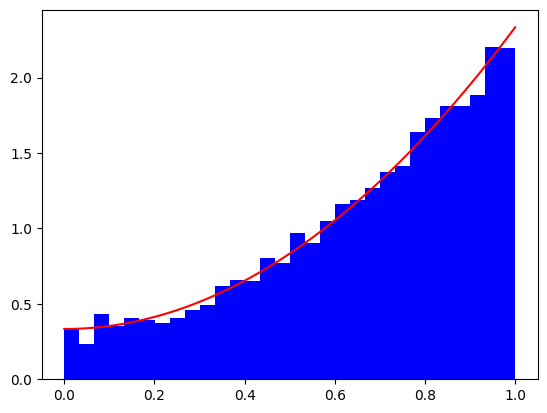

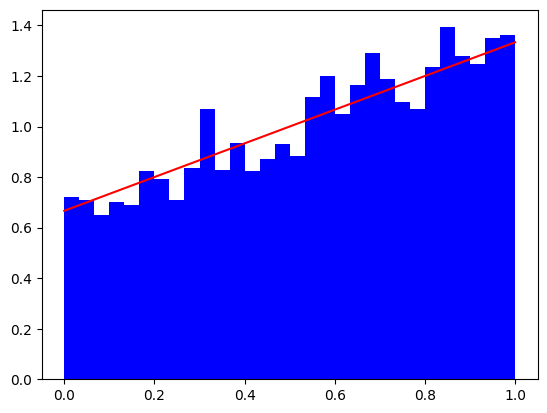

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import random
import matplotlib.pyplot as plt


class ZGenerator:
    def __init__(self, distr_func, x, y, z, low, high):
        self._distr_func = distr_func
        self._x = x
        self._y = y
        self._z = z
        self._inverse_func = None
        self._low = low
        self._high = high

        self._calc_inverse_func()

    def generate(self, z_val: float) -> float:
        uniform_rv = random.uniform(0, 1)
        rv = sp.simplify(self._inverse_func.subs(self._y, uniform_rv).subs(self._z, z_val).evalf())
        return float(rv)

    def get_inverse_func(self):
        return self._inverse_func

    def _calc_inverse_func(self):
        solutions = sp.solve(self._distr_func - self._y, self._x)
        self._inverse_func = self._find_suitable_solution(solutions)
        if self._inverse_func is None:
            raise RuntimeError("Failed to find the inverse function")

    def _find_suitable_solution(self, solutions: list):
        points_to_check = [0, 0.25, 0.5, 0.75, 1]
        for s in solutions:
            for point in points_to_check:
                val = sp.simplify(s.subs(self._y, point).subs(self._z, self._low).evalf())
                if isinstance(val, sp.core.numbers.Float):
                    val = float(val)
                    if val >= self._low and val <= self._high:
                        return s
        return None

def read_distribution_func() -> str:
    distr_func_str = input("Введите многочлен в формате Python (например, 'x**2 + 2*x - 3'): ")
    return str_to_func(distr_func_str)


def str_to_func(func_str: str):
    try:
        distr_func = sp.sympify(func_str)
    except sp.SympifyError:
        print("Ошибка: Некорректный ввод многочлена.")
        exit()
    return distr_func


def create_plot_2d(f_x, x, x_values):
    vals = np.linspace(0, 1, 100)
    f_x_values = [float(f_x.subs(x, v).evalf()) for v in vals]
    plt.plot(vals, f_x_values, color='red')
    plt.hist(x_values, 30, color='blue', density=1)
    plt.show()


def get_rv_generator(F, var, low, high) -> RVGenerator:
    y = sp.symbols("y")
    is_correct_distr_func = check_distr_func(F, var, low, high)
    if not is_correct_distr_func:
        print("Incorrect distr func")
        return

    try:
        generator = RVGenerator(F, var, y, low, high)
    except RuntimeError as ex:
        print(ex)
        return
    return generator


def task1() -> None:
    # random.seed(1000)
    x, y, z = sp.symbols("x y z")

    low = 0
    high = 1
    distr_density_str = '2*(x**2 + z/3)'

    f_x_z = str_to_func(distr_density_str)
    f_x = sp.integrate(f_x_z, (z, 0, 1))
    f_z = sp.integrate(f_x_z, (x, 0, 1))
    f_x_if_z = sp.simplify(f_x_z / f_z)
    f_z_if_x = sp.simplify(f_x_z / f_x)

    F_x = sp.integrate(f_x, (x, 0, x))
    F_z = sp.integrate(f_z, (z, 0, z))
    F_z_if_x = sp.integrate(f_z_if_x, (z, 0, z))

    print("f(x):", f_x)
    print("f(z): ", f_z)
    print("f(x|z):", f_x_if_z)
    print("f(z|x):", f_z_if_x)
    print("F(x): ", F_x)
    print("F(z):", F_z)
    print("F(z|x):", F_z_if_x)

    if f_x != f_x_if_z:
        print("Составляющие двумерной НСВ зависимы т.к. f(x) != f(x|z)")
    else:
        print("Составляющие двумерной НСВ независимы т.к. f(x) = f(x|z)")

    M_x = calc_math_expectation(f_x, x, low, high)
    M_z = calc_math_expectation(f_z, z, low, high)
    print("M(x) = ", M_x)
    print("M(z) = ", M_z)

    D_x = calc_theoretical_dispersion(f_x, x, low, high)
    D_z = calc_theoretical_dispersion(f_z, z, low, high)
    print("D(x) = ", D_x)
    print("D(z) = ", D_z)

    r = calc_theor_correlation(f_x_z, f_x, x, low, high, f_z, z, low, high)
    print("r: ", r)

    num_of_vals_to_generate = 5000
    x_generator = get_rv_generator(F_x, x, low, high)
    x_values = [x_generator.generate() for _ in range(num_of_vals_to_generate)]

    z_values = []
    z_generator = ZGenerator(F_z_if_x, z, y, x, low, high)
    for x in x_values:
        z_values.append(z_generator.generate(x))

    x, y, z = sp.symbols("x y z")

    stat_M_x = calc_statistical_mean(x_values)
    stat_M_z = calc_statistical_mean(z_values)
    print("stat_M_x:", stat_M_x)
    print("stat_M_z:", stat_M_z)


    stat_D_x = calc_dispersion(x_values)
    stat_D_z = calc_dispersion(z_values)
    print("stat_D_x:", stat_D_x)
    print("stat_D_z:", stat_D_z)

    stat_r = calc_correlation(x_values, z_values)
    print("stat_r: ", stat_r)

    create_plot_2d(f_x, x, x_values)
    create_plot_2d(f_z, z, z_values)

task1()

In [17]:
import numpy as np
import sympy as sp
import random
import math
import matplotlib.pyplot as plt
import copy
from collections import Counter


def generate_rv(matrix) -> tuple:
    val_x = random.uniform(0, 1)
    x_p = [sum(matrix[i]) for i in range(len(matrix))]
    x = 0
    curr_p = 0
    for i in range(len(x_p)):
        curr_p += x_p[i]
        if val_x <= curr_p:
            x = i
            break

    y_p = matrix[x]
    val_y = random.uniform(0, sum(y_p))
    curr_p = 0
    y = 0
    for i in range(len(y_p)):
        curr_p += y_p[i]
        if val_y <= curr_p:
            y = i
            break
    return x, y


def is_independent(matrix: list, x_p: list, y_p: list) -> bool:
    for i in range(len(x_p)):
        for j in range(len(y_p)):
            if not math.isclose(matrix[i][j], x_p[i] * y_p[j]):
                return False
    return True


def calc_x_if_y(matrix: list, y_p: list) -> list:
    x_if_y = copy.deepcopy(matrix)
    for j in range(len(y_p)):
        for i in range(len(matrix)):
            x_if_y[i][j] /= y_p[j]
    return x_if_y


def calc_y_if_x(matrix: list, x_p: list) -> list:
    y_if_x = copy.deepcopy(matrix)
    for i in range(len(x_p)):
        for j in range(len(matrix[0])):
            y_if_x[i][j] /= x_p[i]
    return y_if_x


def discrete_expectation(x_p: list) -> float:
    expectation = 0
    for i in range(len(x_p)):
        expectation += i * x_p[i]
    return expectation


def discrete_dispersion(x_p: list) -> float:
    mean = discrete_expectation(x_p)
    mean_square = 0
    for i in range(len(x_p)):
        mean_square += i * i * x_p[i]
    return mean_square - mean**2


def discrete_cov(matrix, x_p, y_p) -> float:
    cov = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            cov += matrix[i][j] * i * j
    cov -= discrete_expectation(x_p) * discrete_expectation(y_p)
    return cov


def discrete_correlation(matrix, x_p, y_p) -> float:
    cov = discrete_cov(matrix, x_p, y_p)
    return cov / (pow(discrete_dispersion(x_p), 1/2) * pow(discrete_dispersion(y_p), 1/2))

def task2():
    matrix = [[0.18, 0.12],
              [0.24, 0.16],
              [0.18, 0.12]]

    # matrix = [[0.18, 0.02, 0.1],
    #           [0.20, 0.16, 0.04],
    #           [0.10, 0.12, 0.08]]

    x_p = [sum(matrix[i]) for i in range(len(matrix))]
    print("x_p: ", x_p)
    y_p = []
    for j in range(len(matrix[0])):
        curr_p = 0
        for i in range(len(matrix)):
            curr_p += matrix[i][j]
        y_p.append(curr_p)

    print("y_p:", y_p)

    if not is_independent(matrix, x_p, y_p):
        print("Составляющие двумерной ДСВ зависимы")
    else:
        print("Составляющие двумерной ДСВ независимы")

    x_if_y = calc_x_if_y(matrix, y_p)
    print("x_if_y:", x_if_y)
    y_if_x = calc_y_if_x(matrix, x_p)
    print("y_if_x:", y_if_x)

    num_of_vals_to_generate = 100000
    x_values = []
    y_values = []
    for _ in range(num_of_vals_to_generate):
        x, y = generate_rv(matrix)
        x_values.append(x)
        y_values.append(y)

    x_counts = Counter(x_values)
    x_counts = dict(sorted(x_counts.items()))
    y_counts = Counter(y_values)
    y_counts = dict(sorted(y_counts.items()))

    plt.bar(list(x_counts.keys()), list(x_counts.values()), color='red')
    plt.xticks([i for i in range(len(x_p))])
    plt.show()
    plt.bar(list(y_counts.keys()), list(y_counts.values()), color='green')
    plt.xticks([i for i in range(len(y_p))])
    plt.show()

    M_x = discrete_expectation(x_p)
    M_y = discrete_expectation(y_p)
    print("M(x):", M_x)
    print("M(y)", M_y)

    D_x = discrete_dispersion(x_p)
    D_y = discrete_dispersion(y_p)
    print("D(x):", D_x)
    print("D(y):", D_y)

    r = discrete_correlation(matrix, x_p, y_p)
    print("r:", r)

    stat_M_x = calc_statistical_mean(x_values)
    stat_M_y = calc_statistical_mean(y_values)
    print("stat_M(x):", stat_M_x)
    print("stat_M(y):", stat_M_y)

    stat_D_x = calc_dispersion(x_values)
    stat_D_y = calc_dispersion(y_values)
    print("stat_D(x):", stat_D_x)
    print("stat_D(y):", stat_D_y)

    stat_r = calc_correlation(x_values, y_values)
    print("stat_r: ", stat_r)




x_p:  [0.3, 0.4, 0.3]
y_p: [0.6, 0.4]
Составляющие двумерной ДСВ независимы
x_if_y: [[0.3, 0.3], [0.4, 0.39999999999999997], [0.3, 0.3]]
y_if_x: [[0.6, 0.4], [0.6, 0.39999999999999997], [0.6, 0.4]]


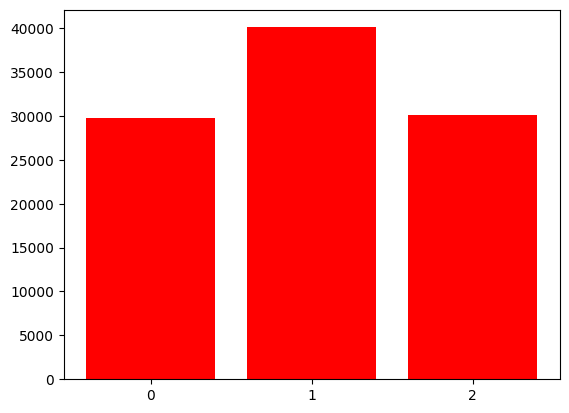

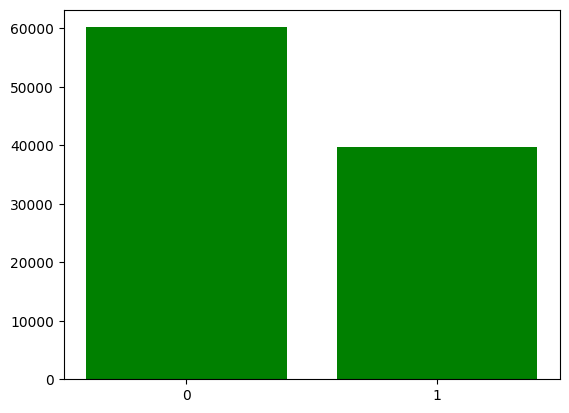

M(x): 1.0
M(y) 0.4
D(x): 0.6000000000000001
D(y): 0.24
r: 0.0
stat_M(x): 1.00286
stat_M(y): 0.39797
stat_D(x): 0.5990378107791775
stat_D(y): 0.2395922750232307
stat_r:  -0.008705880471702994


In [18]:
task2()